In [1]:

# NAME_Siva Harshitha Sreeram


# Dataset Preparation and Preprocessing

We will prepare a dataset of tomato images for a quality classification task. The process involves several key steps:

1. **Setting up the Environment**: We will import the necessary libraries from PyTorch and Torchvision, etc.
2. **Defining Data Transformations**: We will create a pipeline to resize and normalize the images to a standard format suitable for deep learning models.
3. **Loading the Dataset**: We will load the images from a directory structure using `ImageFolder`, which automatically assigns labels based on folder names.
4. **Splitting the Dataset**: The dataset will be split into training (80%) and validation (20%) sets to allow for model evaluation during training.
5. **Creating DataLoaders**: We will create `DataLoader` instances for both sets to efficiently load data in batches.
6. **Inspecting the Dataset**: Finally, we will display a summary of our prepared dataset, including class labels, image counts per category, and the shape of a sample data batch.


## Python Code


## 1. Import Required Libraries and Configurations


In [2]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# === Configurations ===
DATASET_PATH = r"\\DESKTOP-KHVOSK3\Users\HP\Desktop\Tomato Project\Tomatoes"
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
TRAIN_SPLIT = 0.8
SEED = 42
MAX_IMAGES = 9
GRID_COLS = GRID_ROWS = 3
NUM_EPOCHS = 10
LEARNING_RATE = 0.001


## 2. Define Data Transformations


In [3]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

inv_normalize = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])


## 3. Load and Split Dataset


## Input

In [4]:
full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)
print(f"Total images: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")


Total images: 8
Classes: ['bad_quality', 'good_quality']


## Output

In [5]:
print("end=Total images: 8 \nClasses: ['bad_quality', 'good_quality']")


end=Total images: 8 
Classes: ['bad_quality', 'good_quality']


## Input

In [6]:
TRAIN_SPLIT = 0.8


In [7]:
train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size

torch.manual_seed(SEED)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform


## 4. Create DataLoaders and Analyze Class Distribution


In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_labels = full_dataset.class_to_idx
label_map = {v: k for k, v in class_labels.items()}

def count_labels(dataset):
    return Counter([full_dataset.targets[i] for i in dataset.indices])

train_counts = count_labels(train_dataset)
val_counts = count_labels(val_dataset)

print("Train class counts:")
for k, v in train_counts.items():
    print(f"  {label_map[k]}: {v}")

print("Validation class counts:")
for k, v in val_counts.items():
    print(f"  {label_map[k]}: {v}")


Train class counts:
  good_quality: 3
  bad_quality: 3
Validation class counts:
  good_quality: 2


## 5. Visualize Sample Images


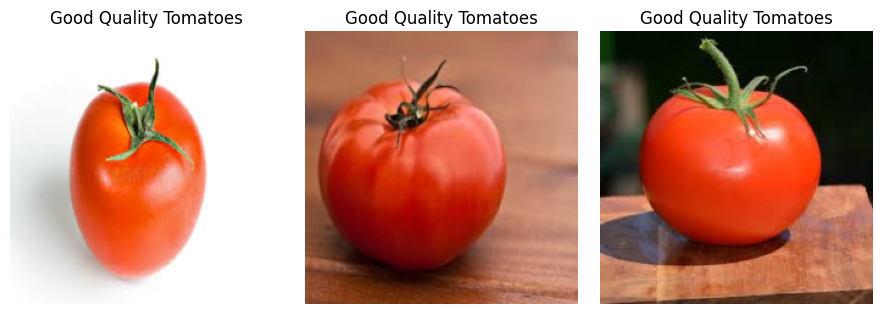

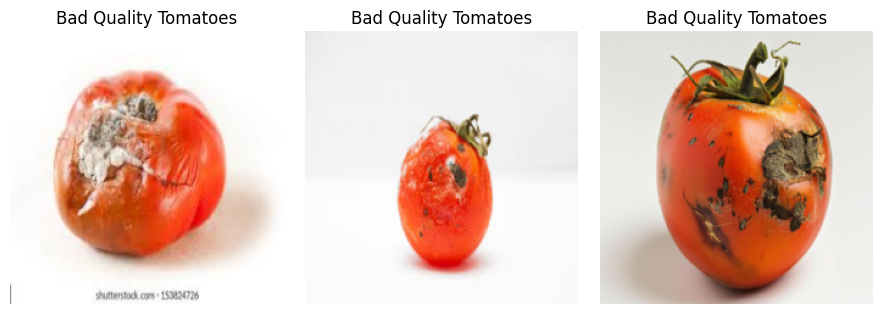

In [9]:
def show_images(images, title):
    plt.figure(figsize=(GRID_COLS*3, GRID_ROWS*3))
    for i, img_tensor in enumerate(images):
        ax = plt.subplot(GRID_ROWS, GRID_COLS, i+1)
        img = inv_normalize(img_tensor).permute(1,2,0).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def collect_images(loader, label_idx, max_images):
    collected = []
    for imgs, lbls in loader:
        for i in range(len(lbls)):
            if lbls[i].item() == label_idx:
                collected.append(imgs[i])
                if len(collected) >= max_images:
                    return collected
    return collected

if 'good_quality' in class_labels and 'bad_quality' in class_labels:
    good_idx = class_labels['good_quality']
    bad_idx = class_labels['bad_quality']

    good_imgs = collect_images(train_loader, good_idx, MAX_IMAGES)
    bad_imgs = collect_images(train_loader, bad_idx, MAX_IMAGES)

    if good_imgs:
        show_images(good_imgs, "Good Quality Tomatoes")
    if bad_imgs:
        show_images(bad_imgs, "Bad Quality Tomatoes")


## 6. Plot Class Distribution


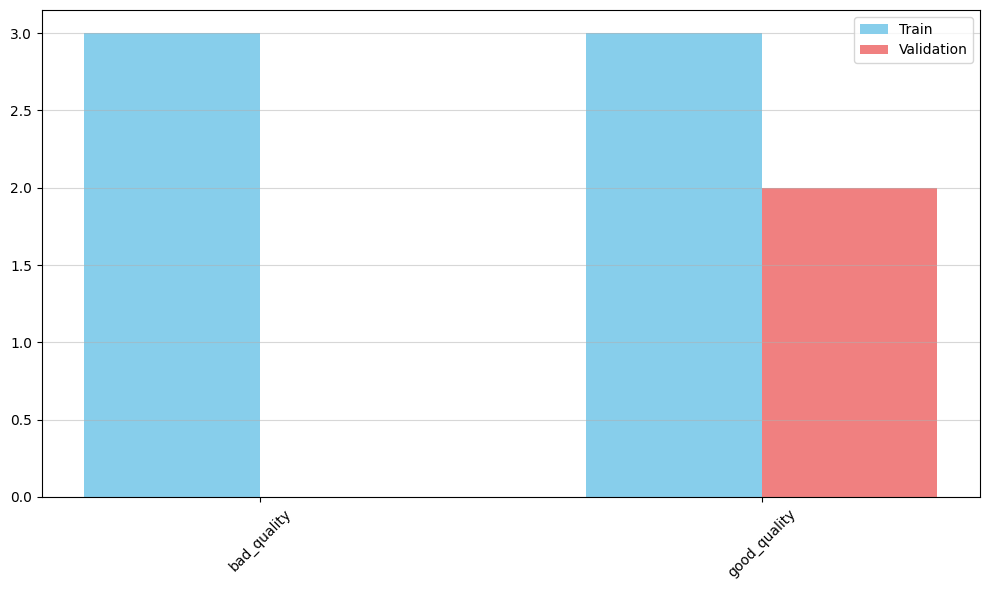

In [10]:
def plot_distribution(train_counts, val_counts):
    classes = sorted(class_labels.keys())
    indices = np.arange(len(classes))
    width = 0.35

    train_vals = [train_counts.get(class_labels[c], 0) for c in classes]
    val_vals = [val_counts.get(class_labels[c], 0) for c in classes]

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(indices - width/2, train_vals, width, label='Train', color='skyblue')
    ax.bar(indices + width/2, val_vals, width, label='Validation', color='lightcoral')

    ax.set_xticks(indices)
    ax.set_xticklabels(classes, rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.5)
    plt.show()

plot_distribution(train_counts, val_counts)



## 7. Build and Configure the Model


In [11]:
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

num_classes = len(full_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Using device: cpu


## 8. Sanity Check on Training Labels


In [12]:
all_train_labels = []
for _, labels in train_loader:
    all_train_labels.extend(labels.tolist())
unique_labels = set(all_train_labels)
print(f"Unique labels in training data: {unique_labels}")
if len(unique_labels) < 2:
    print("Warning: Less than 2 classes in training data.")


Unique labels in training data: {0, 1}


## 9. Training Loop with Validation and Checkpoints


In [13]:
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1} done. Avg Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved best model at epoch {epoch+1} with accuracy: {best_val_acc:.2f}%")


Epoch 1, Batch 1, Loss: 0.8763
Epoch 1 done. Avg Loss: 0.8763
Validation Accuracy: 100.00%
Saved best model at epoch 1 with accuracy: 100.00%
Epoch 2, Batch 1, Loss: 0.0037
Epoch 2 done. Avg Loss: 0.0037
Validation Accuracy: 100.00%
Epoch 3, Batch 1, Loss: 0.0008
Epoch 3 done. Avg Loss: 0.0008
Validation Accuracy: 100.00%
Epoch 4, Batch 1, Loss: 0.0005
Epoch 4 done. Avg Loss: 0.0005
Validation Accuracy: 100.00%
Epoch 5, Batch 1, Loss: 0.0003
Epoch 5 done. Avg Loss: 0.0003
Validation Accuracy: 100.00%
Epoch 6, Batch 1, Loss: 0.0002
Epoch 6 done. Avg Loss: 0.0002
Validation Accuracy: 100.00%
Epoch 7, Batch 1, Loss: 0.0001
Epoch 7 done. Avg Loss: 0.0001
Validation Accuracy: 100.00%
Epoch 8, Batch 1, Loss: 0.0001
Epoch 8 done. Avg Loss: 0.0001
Validation Accuracy: 100.00%
Epoch 9, Batch 1, Loss: 0.0000
Epoch 9 done. Avg Loss: 0.0000
Validation Accuracy: 100.00%
Epoch 10, Batch 1, Loss: 0.0000
Epoch 10 done. Avg Loss: 0.0000
Validation Accuracy: 100.00%


## 10. Final Evaluation on Validation Set


In [14]:
print("\n=== Final Evaluation on Validation Set ===")
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print("Predicted:", predicted.cpu().numpy())
        print("Actual:   ", labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_val_accuracy = 100 * correct / total
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")



=== Final Evaluation on Validation Set ===
Predicted: [1 1]
Actual:    [1 1]
Final Validation Accuracy: 100.00%


**Conclusion**  
Because preprocessing cleans up and prepares our raw data such as tomato photos for the model to learn from, it is absolutely essential for deep learning. It guarantees that everything is scaled and sized appropriately, which aids in the model's quicker and more precise learning. We successfully completed the technical steps of resizing, normalizing, and splitting the data for our tomato classification task.  

The most important lesson, though, is that our dataset is incredibly small (just 8 photos!) and unbalanced, particularly in the test set that excludes "bad quality" tomatoes. This implies that our model will not be able to learn well or consistently distinguish between good and bad tomatoes, even with ideal preprocessing.  

In order to provide our deep learning model with enough data to truly learn and perform well, the most crucial next step is to gather a large number of additional images, particularly for the "bad quality" category.
